<a href="https://colab.research.google.com/github/GeneSUN/data-science-engineering/blob/main/categorical_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install catboost lightgbm torch torchvision torchaudio scikit-learn pandas numpy matplotlib


In [ ]:
# ============================================================
# Notebook: Categorical Features Demo
#   - Synthetic dataset with numeric + categorical (high-cardinality)
#   - Compare: CatBoost vs LightGBM(native categorical) vs Embedding Network
#   - Task: Binary classification (can be adapted to regression easily)
# ============================================================

# -------------------------------
# Cell 0) (Optional) Install deps
# -------------------------------
# If running in a fresh environment, uncomment:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score

np.random.seed(42)

In [ ]:

#@title Synthesize dataset (numeric + categorical)
# ---------------------------------------------
def make_synthetic_tabular(
    n=200_000,
    n_regions=500,
    n_devices=50,
    n_plans=20,
    n_weekdays=7,
    noise=0.7,
    seed=42,
):
    """
    Create a dataset where:
      - Numeric features (x1, x2, x3) have linear + interaction effects
      - Categorical features include high-cardinality 'region'
      - There are structured category effects + interactions (region x plan, device x x2)
      - Target is binary classification generated from a logistic model
    """
    rng = np.random.default_rng(seed)

    # Numeric features
    x1 = rng.normal(0, 1, n)
    x2 = rng.normal(0, 1, n)
    x3 = rng.uniform(-2, 2, n)

    # Categorical features
    region = rng.integers(0, n_regions, n)
    device = rng.integers(0, n_devices, n)
    plan = rng.integers(0, n_plans, n)
    weekday = rng.integers(0, n_weekdays, n)

    # Create category effects (learnable latent structure)
    # Region effects: heavy-tailed / uneven importance
    region_effect = rng.normal(0, 0.8, n_regions)
    # Make a few regions very influential (simulate "hot markets")
    hot = rng.choice(n_regions, size=max(5, n_regions // 50), replace=False)
    region_effect[hot] += rng.normal(1.5, 0.5, size=hot.shape[0])

    device_effect = rng.normal(0, 0.5, n_devices)
    plan_effect = rng.normal(0, 0.6, n_plans)
    weekday_effect = np.array([0.2, 0.1, 0.0, -0.05, 0.05, 0.1, 0.25])  # mild pattern

    # Interaction: region x plan (sparse-ish)
    # For a subset of (region, plan) pairs, add extra effect
    n_pairs = int(0.03 * n_regions * n_plans)
    pair_regions = rng.integers(0, n_regions, n_pairs)
    pair_plans = rng.integers(0, n_plans, n_pairs)
    pair_effect = rng.normal(0, 0.9, n_pairs)

    # Build a lookup table for pair effects
    pair_table = {}
    for r, p, e in zip(pair_regions, pair_plans, pair_effect):
        pair_table[(int(r), int(p))] = float(e)

    def get_pair_effect(r, p):
        # vectorized lookup via python dict is slow; do a numpy-friendly trick:
        # We'll approximate by hashing (r, p) to a key and matching.
        # For demo purposes, keep it simple: use list comprehension for smaller n
        return np.array([pair_table.get((int(rr), int(pp)), 0.0) for rr, pp in zip(r, p)], dtype=np.float32)

    rp_effect = get_pair_effect(region, plan)

    # Nonlinear + interaction terms
    lin = (
        1.1 * x1
        - 0.8 * x2
        + 0.6 * np.sin(x3)
        + 0.7 * (x1 * (x3 > 0))
        + 0.5 * (x2 * (device < (n_devices // 4)))  # device-dependent sensitivity to x2
        + region_effect[region]
        + device_effect[device]
        + plan_effect[plan]
        + weekday_effect[weekday]
        + rp_effect
    )

    # Add noise
    lin += rng.normal(0, noise, n)

    # Logistic -> probability -> binary label
    prob = 1 / (1 + np.exp(-lin))
    y = rng.binomial(1, prob, n)

    df = pd.DataFrame({
        "x1": x1.astype(np.float32),
        "x2": x2.astype(np.float32),
        "x3": x3.astype(np.float32),
        "region": region.astype(np.int32),
        "device": device.astype(np.int32),
        "plan": plan.astype(np.int32),
        "weekday": weekday.astype(np.int32),
        "y": y.astype(np.int32),
    })
    return df

df = make_synthetic_tabular(n=200_000, n_regions=500, seed=42)
df.head(), df.shape, df["y"].mean()


(         x1        x2        x3  region  device  plan  weekday  y
 0  0.304717  2.617353 -0.130188     326      10     8        3  0
 1 -1.039984 -0.139567  1.676910     439      24    11        4  0
 2  0.750451 -0.464516  0.220485      52      30    15        0  1
 3  0.940565 -1.134059 -0.115193     437      32    12        5  1
 4 -1.951035 -0.255353 -1.899659     335      10     0        2  0,
 (200000, 8),
 0.531665)

# encoding

In [ ]:
pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.9 MB/s eta 0:00:00


In [ ]:


import numpy as np
import pandas as pd
import category_encoders as ce


target = "y"
cat_cols = ["region", "device", "plan", "weekday"]
num_cols = ["x1", "x2", "x3"]

view_n = 12
df_view = df[num_cols + cat_cols + [target]].head(view_n).copy()
df_view


,x1,x2,x3,region,device,plan,weekday,y
0,0.304717,2.617353,-0.130188,326,10,8,3,0
1,-1.039984,-0.139567,1.676910,439,24,11,4,0
2,0.750451,-0.464516,0.220485,52,30,15,0,1
3,0.940565,-1.134059,-0.115193,437,32,12,5,1
4,-1.951035,-0.255353,-1.899659,335,10,0,2,0
5,-1.302179,-0.273072,0.031793,312,14,1,5,0
6,0.127840,-0.246754,-1.560173,209,22,13,1,0
7,-0.316243,0.379914,0.791586,109,45,9,3,1
8,-0.016801,-0.896081,0.643937,494,10,8,4,1
9,-0.853044,-1.254370,-1.945438,415,20,16,5,0


In [ ]:
# One-Hot Encoding (OHE)

ohe = ce.OneHotEncoder(cols=cat_cols, handle_unknown="value", use_cat_names=True)
df_ohe = show_encoded(df_view, ohe, "OneHotEncoder")
df_ohe


OneHotEncoder
Input shape: (12, 7) -> Encoded shape: (12, 41)
Encoded categorical columns (first 15): ['region_326.0', 'region_439.0', 'region_52.0', 'region_437.0', 'region_335.0', 'region_312.0', 'region_209.0', 'region_109.0', 'region_494.0', 'region_415.0', 'region_175.0', 'region_379.0', 'device_10.0', 'device_24.0', 'device_30.0']


,x1,x2,x3,region_326.0,region_439.0,region_52.0,region_437.0,region_335.0,region_312.0,region_209.0,...,plan_9.0,plan_16.0,weekday_3.0,weekday_4.0,weekday_0.0,weekday_5.0,weekday_2.0,weekday_1.0,weekday_6.0,y
0,0.304717,2.617353,-0.130188,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-1.039984,-0.139567,1.676910,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.750451,-0.464516,0.220485,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.940565,-1.134059,-0.115193,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-1.951035,-0.255353,-1.899659,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,-1.302179,-0.273072,0.031793,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
6,0.127840,-0.246754,-1.560173,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,-0.316243,0.379914,0.791586,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
8,-0.016801,-0.896081,0.643937,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,-0.853044,-1.254370,-1.945438,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
# Cell 4) Ordinal Encoding

ord_enc = ce.OrdinalEncoder(cols=cat_cols, handle_unknown="value", handle_missing="value")
df_ord = show_encoded(df_view, ord_enc, "OrdinalEncoder")
df_ord


OrdinalEncoder
Input shape: (12, 7) -> Encoded shape: (12, 7)
Encoded categorical columns (first 15): ['region', 'device', 'plan', 'weekday']


,x1,x2,x3,region,device,plan,weekday,y
0,0.304717,2.617353,-0.130188,1,1,1,1,0
1,-1.039984,-0.139567,1.676910,2,2,2,2,0
2,0.750451,-0.464516,0.220485,3,3,3,3,1
3,0.940565,-1.134059,-0.115193,4,4,4,4,1
4,-1.951035,-0.255353,-1.899659,5,1,5,5,0
5,-1.302179,-0.273072,0.031793,6,5,6,4,0
6,0.127840,-0.246754,-1.560173,7,6,7,6,0
7,-0.316243,0.379914,0.791586,8,7,8,1,1
8,-0.016801,-0.896081,0.643937,9,1,1,2,1
9,-0.853044,-1.254370,-1.945438,10,8,9,4,0


In [ ]:
# ------------------------------------------------------------
# Cell 5) Count Encoding
#   - Replace each category with its frequency (count) in the FIT data.
#   - Example: region=123 appears 400 times -> region becomes 400
#   - Compact (one column per categorical feature).
# ------------------------------------------------------------
cnt_enc = ce.CountEncoder(cols=cat_cols, normalize=False, handle_unknown=0, handle_missing=0)
df_cnt = show_encoded(df_view, cnt_enc, "CountEncoder (raw counts)")
df_cnt


CountEncoder (raw counts)
Input shape: (12, 7) -> Encoded shape: (12, 7)
Encoded categorical columns (first 15): ['region', 'device', 'plan', 'weekday']


,x1,x2,x3,region,device,plan,weekday,y
0,0.304717,2.617353,-0.130188,1,3,2,2,0
1,-1.039984,-0.139567,1.676910,1,1,2,2,0
2,0.750451,-0.464516,0.220485,1,1,1,1,1
3,0.940565,-1.134059,-0.115193,1,1,1,3,1
4,-1.951035,-0.255353,-1.899659,1,3,1,1,0
5,-1.302179,-0.273072,0.031793,1,1,1,3,0
6,0.127840,-0.246754,-1.560173,1,1,1,1,0
7,-0.316243,0.379914,0.791586,1,1,2,2,1
8,-0.016801,-0.896081,0.643937,1,3,2,2,1
9,-0.853044,-1.254370,-1.945438,1,1,1,3,0


In [ ]:
# ------------------------------------------------------------
# Cell 6) Frequency Encoding (normalized count)
# Meaning:
#   - Same as count but divided by total rows in FIT data
#   - Values in [0,1]
# ------------------------------------------------------------
freq_enc = ce.CountEncoder(cols=cat_cols, normalize=True, handle_unknown=0, handle_missing=0)
df_freq = show_encoded(df_view, freq_enc, "CountEncoder (normalized = frequency)")
df_freq


CountEncoder (normalized = frequency)
Input shape: (12, 7) -> Encoded shape: (12, 7)
Encoded categorical columns (first 15): ['region', 'device', 'plan', 'weekday']


,x1,x2,x3,region,device,plan,weekday,y
0,0.304717,2.617353,-0.130188,0.083333,0.250000,0.166667,0.166667,0
1,-1.039984,-0.139567,1.676910,0.083333,0.083333,0.166667,0.166667,0
2,0.750451,-0.464516,0.220485,0.083333,0.083333,0.083333,0.083333,1
3,0.940565,-1.134059,-0.115193,0.083333,0.083333,0.083333,0.250000,1
4,-1.951035,-0.255353,-1.899659,0.083333,0.250000,0.083333,0.083333,0
5,-1.302179,-0.273072,0.031793,0.083333,0.083333,0.083333,0.250000,0
6,0.127840,-0.246754,-1.560173,0.083333,0.083333,0.083333,0.083333,0
7,-0.316243,0.379914,0.791586,0.083333,0.083333,0.166667,0.166667,1
8,-0.016801,-0.896081,0.643937,0.083333,0.250000,0.166667,0.166667,1
9,-0.853044,-1.254370,-1.945438,0.083333,0.083333,0.083333,0.250000,0


In [ ]:
# ------------------------------------------------------------
# Cell 8) Hashing Encoding
# Meaning:
#   - Hash categories into a fixed number of columns (n_components)
#   - Collisions possible (different categories share columns)
#   - Great when cardinality is huge.
# ------------------------------------------------------------
hash_enc = ce.HashingEncoder(cols=cat_cols, n_components=16)  # small so you can "see" it
df_hash = show_encoded(df_view, hash_enc, "HashingEncoder (n_components=16)")
df_hash


HashingEncoder (n_components=16)
Input shape: (12, 7) -> Encoded shape: (12, 19)
Encoded categorical columns (first 15): ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14']


,x1,x2,x3,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,y
0,0.304717,2.617353,-0.130188,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,-1.039984,-0.139567,1.676910,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0
2,0.750451,-0.464516,0.220485,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1
3,0.940565,-1.134059,-0.115193,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4,-1.951035,-0.255353,-1.899659,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5,-1.302179,-0.273072,0.031793,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0
6,0.127840,-0.246754,-1.560173,0,0,1,0,0,0,0,0,0,2,0,1,0,0,0,0,0
7,-0.316243,0.379914,0.791586,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1
8,-0.016801,-0.896081,0.643937,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1
9,-0.853044,-1.254370,-1.945438,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# ------------------------------------------------------------
# Cell 9) Target Encoding (Supervised)
# Meaning:
#   - Replace each category with mean(y) among rows with that category
#   - Usually includes smoothing to avoid overfitting for rare categories.
#   - Needs y to fit.
# ------------------------------------------------------------
tgt_enc = ce.TargetEncoder(cols=cat_cols, smoothing=10.0)
df_tgt = show_encoded(df_view, tgt_enc, "TargetEncoder (mean(y) with smoothing)", y_col="y")
df_tgt


TargetEncoder (mean(y) with smoothing)
Input shape: (12, 7) -> Encoded shape: (12, 7)
Encoded categorical columns (first 15): ['region', 'device', 'plan', 'weekday']


,x1,x2,x3,region,device,plan,weekday,y
0,0.304717,2.617353,-0.130188,0.362455,0.403795,0.428488,0.428488,0
1,-1.039984,-0.139567,1.676910,0.362455,0.362455,0.428488,0.428488,0
2,0.750451,-0.464516,0.220485,0.492563,0.492563,0.492563,0.492563,1
3,0.940565,-1.134059,-0.115193,0.492563,0.492563,0.492563,0.403795,1
4,-1.951035,-0.255353,-1.899659,0.362455,0.403795,0.362455,0.362455,0
5,-1.302179,-0.273072,0.031793,0.362455,0.362455,0.362455,0.403795,0
6,0.127840,-0.246754,-1.560173,0.362455,0.362455,0.362455,0.362455,0
7,-0.316243,0.379914,0.791586,0.492563,0.492563,0.428488,0.428488,1
8,-0.016801,-0.896081,0.643937,0.492563,0.403795,0.428488,0.428488,1
9,-0.853044,-1.254370,-1.945438,0.362455,0.362455,0.362455,0.403795,0


In [ ]:
# ------------------------------------------------------------
# Cell 11) CatBoost Encoder (Supervised)
# Meaning:
#   - A target-statistics encoder inspired by CatBoost’s idea
#   - Adds noise / Bayesian-like smoothing (depending on params)
#   - Needs y to fit.
# ------------------------------------------------------------
cb_enc = ce.CatBoostEncoder(cols=cat_cols, a=1.0, sigma=0.05, random_state=42)
df_cb = show_encoded(df_view, cb_enc, "CatBoostEncoder (target stats variant)", y_col="y")
df_cb


CatBoostEncoder (target stats variant)
Input shape: (12, 7) -> Encoded shape: (12, 7)
Encoded categorical columns (first 15): ['region', 'device', 'plan', 'weekday']


,x1,x2,x3,region,device,plan,weekday,y
0,0.304717,2.617353,-0.130188,0.427015,0.421708,0.405325,0.421018,0
1,-1.039984,-0.139567,1.676910,0.413786,0.376807,0.418978,0.375840,0
2,0.750451,-0.464516,0.220485,0.430160,0.380731,0.392688,0.388996,1
3,0.940565,-1.134059,-0.115193,0.448396,0.404952,0.424494,0.420768,1
4,-1.951035,-0.255353,-1.899659,0.411788,0.197783,0.404153,0.432051,0
5,-1.302179,-0.273072,0.031793,0.411789,0.423213,0.410590,0.714403,0
6,0.127840,-0.246754,-1.560173,0.449567,0.397749,0.404131,0.414257,0
7,-0.316243,0.379914,0.791586,0.432655,0.387244,0.455256,0.205197,1
8,-0.016801,-0.896081,0.643937,0.406886,0.149067,0.208193,0.192932,1
9,-0.853044,-1.254370,-1.945438,0.427970,0.411963,0.394631,0.455226,0


In [ ]:
# ------------------------------------------------------------
# Cell 2) Utility: apply encoder and show "before vs after"
# ------------------------------------------------------------
def show_encoded(df_in: pd.DataFrame, encoder, encoder_name: str, y_col="y"):
    """
    Apply encoder to categorical columns and return a nice view:
      - Keeps numeric cols unchanged
      - Shows encoded categorical output
      - Prints shape and column examples
    NOTE:
      - Some encoders need y (supervised encoders): Target, LeaveOneOut, CatBoost, WOE, etc.
    """
    X_cat = df_in[cat_cols].copy()
    X_num = df_in[num_cols].copy()
    y = df_in[y_col].values if (y_col in df_in.columns) else None

    # Fit/transform
    try:
        if y is not None:
            X_cat_enc = encoder.fit_transform(X_cat, y)
        else:
            X_cat_enc = encoder.fit_transform(X_cat)
    except TypeError:
        # for encoders that don't accept y in fit_transform
        X_cat_enc = encoder.fit_transform(X_cat)

    out = pd.concat([X_num.reset_index(drop=True), X_cat_enc.reset_index(drop=True), df_in[[y_col]].reset_index(drop=True)], axis=1)

    print("=" * 80)
    print(f"{encoder_name}")
    print("Input shape:", df_in[num_cols + cat_cols].shape, "-> Encoded shape:", out.drop(columns=[y_col]).shape)
    print("Encoded categorical columns (first 15):", list(X_cat_enc.columns)[:15])
    print("=" * 80)

    return out




In [ ]:

target = "y"
cat_cols = ["region", "device", "plan", "weekday"]
num_cols = ["x1", "x2", "x3"]
all_cols = num_cols + cat_cols

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])

X_train = train_df[all_cols].copy()
y_train = train_df[target].values
X_test = test_df[all_cols].copy()
y_test = test_df[target].values

print("Train:", X_train.shape, "Test:", X_test.shape, "Pos rate train:", y_train.mean(), "test:", y_test.mean())


Train: (160000, 7) Test: (40000, 7) Pos rate train: 0.5316625 test: 0.531675


# 3) Model A: CatBoost (native categorical handling)

In [ ]:
from catboost import CatBoostClassifier, Pool

# CatBoost can take categorical columns by index.
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

cat_model = CatBoostClassifier(
                                iterations=800,
                                depth=8,
                                learning_rate=0.08,
                                loss_function="Logloss",
                                eval_metric="AUC",
                                random_seed=42,
                                verbose=100,
                                # Good defaults for noisy synthetic data:
                                l2_leaf_reg=3.0,
                                subsample=0.8,
                            )

cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

cat_pred_proba = cat_model.predict_proba(X_test)[:, 1]
cat_pred = (cat_pred_proba >= 0.5).astype(int)

cat_auc = roc_auc_score(y_test, cat_pred_proba)
cat_ll = log_loss(y_test, cat_pred_proba)
cat_acc = accuracy_score(y_test, cat_pred)

print("\n[CatBoost]")
print("AUC:", round(cat_auc, 4), "LogLoss:", round(cat_ll, 4), "Acc:", round(cat_acc, 4))

0:	test: 0.7914929	best: 0.7914929 (0)	total: 638ms	remaining: 8m 30s
100:	test: 0.8353574	best: 0.8353574 (100)	total: 29.2s	remaining: 3m 22s
200:	test: 0.8365460	best: 0.8365460 (200)	total: 57.1s	remaining: 2m 50s
300:	test: 0.8367251	best: 0.8367286 (299)	total: 1m 24s	remaining: 2m 20s
400:	test: 0.8367267	best: 0.8368689 (352)	total: 1m 51s	remaining: 1m 50s
500:	test: 0.8365673	best: 0.8368689 (352)	total: 2m 17s	remaining: 1m 22s
600:	test: 0.8364629	best: 0.8368689 (352)	total: 2m 46s	remaining: 55s
700:	test: 0.8363562	best: 0.8368689 (352)	total: 3m 13s	remaining: 27.4s
799:	test: 0.8362103	best: 0.8368689 (352)	total: 3m 42s	remaining: 0us

bestTest = 0.8368689036
bestIteration = 352

Shrink model to first 353 iterations.

[CatBoost]
AUC: 0.8369 LogLoss: 0.4949 Acc: 0.7553


# 4) Model B: LightGBM (native categorical handling)

In [ ]:
from lightgbm import LGBMClassifier

X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

# Convert categorical columns to 'category' dtype (native handling), categorical columns as pandas 'category' dtype
for c in cat_cols:
    X_train_lgb[c] = X_train_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")

lgb_model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

lgb_model.fit(
    X_train_lgb, y_train,
    eval_set=[(X_test_lgb, y_test)],
    eval_metric="auc",
    callbacks=[],
)

lgb_pred_proba = lgb_model.predict_proba(X_test_lgb)[:, 1]
lgb_pred = (lgb_pred_proba >= 0.5).astype(int)

lgb_auc = roc_auc_score(y_test, lgb_pred_proba)
lgb_ll = log_loss(y_test, lgb_pred_proba)
lgb_acc = accuracy_score(y_test, lgb_pred)

print("\n[LightGBM (native categorical)]")
print("AUC:", round(lgb_auc, 4), "LogLoss:", round(lgb_ll, 4), "Acc:", round(lgb_acc, 4))


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 85066, number of negative: 74934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531663 -> initscore=0.126820
[LightGBM] [Info] Start training from score 0.126820

[LightGBM (native categorical)]
AUC: 0.8198 LogLoss: 0.5507 Acc: 0.741


# 5) Model C: Embedding Network (PyTorch)

In [ ]:


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", device_torch)

# For synthetic data categories already integer-coded, but in real life
# you would map strings -> ids using train data.
# We'll still create vocab sizes:
vocab_sizes = {
    "region": int(df["region"].nunique()),
    "device": int(df["device"].nunique()),
    "plan": int(df["plan"].nunique()),
    "weekday": int(df["weekday"].nunique()),
}
vocab_sizes

class TabDataset(Dataset):
    def __init__(self, X_num: np.ndarray, X_cat: np.ndarray, y: np.ndarray):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        return self.X_num[i], self.X_cat[i], self.y[i]

# Build numpy arrays
X_train_num = X_train[num_cols].to_numpy()
X_test_num = X_test[num_cols].to_numpy()

X_train_cat = X_train[cat_cols].to_numpy()
X_test_cat = X_test[cat_cols].to_numpy()

train_ds = TabDataset(X_train_num, X_train_cat, y_train)
test_ds = TabDataset(X_test_num, X_test_cat, y_test)

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=4096, shuffle=False, num_workers=0)


Torch device: cpu


## Define Embedding MLP model

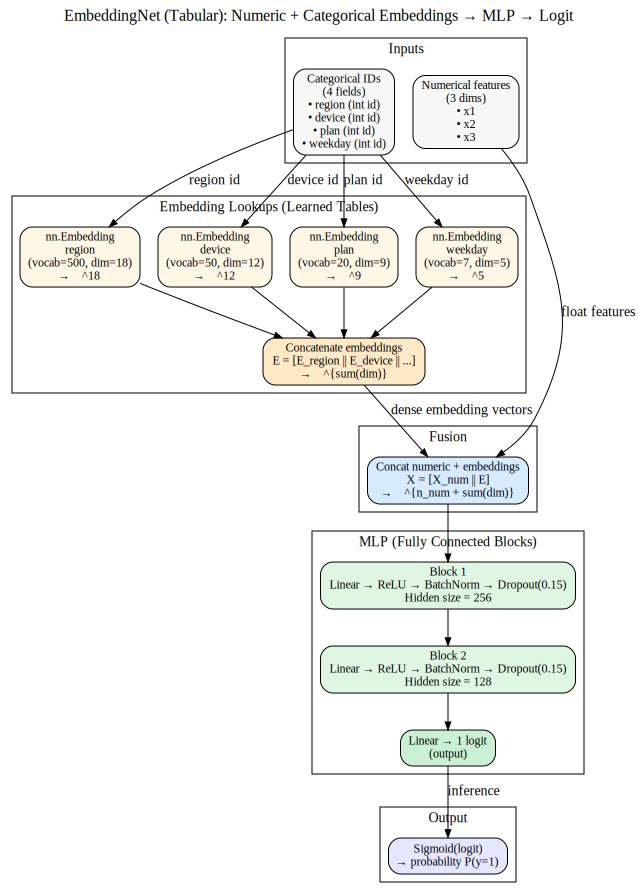

In [ ]:
#@title embedding_net_architecture
from graphviz import Digraph

def draw_embedding_net_architecture(
    num_cols=("x1", "x2", "x3"),
    cat_cols=("region", "device", "plan", "weekday"),
    emb_dims=(("region", 500, 18), ("device", 50, 12), ("plan", 20, 9), ("weekday", 7, 5)),
    hidden_sizes=(256, 128),
    dropout=0.15,
    title="EmbeddingNet (Tabular): Numeric + Categorical Embeddings → MLP → Logit"
):
    """
    Draw the structure of the EmbeddingNet:
      - Numeric inputs (float) go directly to concat
      - Each categorical input (int ids) goes to Embedding(vocab, dim)
      - All are concatenated and passed through MLP blocks
    """
    dot = Digraph("EmbeddingNet", format="png")
    dot.attr(rankdir="TD", fontsize="16", labelloc="t", label=title)
    dot.attr("node", shape="box", style="rounded,filled", fillcolor="white", fontsize="12")
    dot.attr("edge", arrowsize="0.8")

    # --- Input cluster ---
    with dot.subgraph(name="cluster_inputs") as c:
        c.attr(label="Inputs", fontsize="14")
        c.attr("node", fillcolor="#f7f7f7")

        # Numeric inputs
        c.node("num_in", f"Numerical features\n({len(num_cols)} dims)\n" + "\n".join([f"• {x}" for x in num_cols]))

        # Categorical inputs (IDs)
        c.node("cat_in", f"Categorical IDs\n({len(cat_cols)} fields)\n" + "\n".join([f"• {x} (int id)" for x in cat_cols]))

    # --- Embedding cluster ---
    with dot.subgraph(name="cluster_emb") as c:
        c.attr(label="Embedding Lookups (Learned Tables)", fontsize="14")
        c.attr("node", fillcolor="#fff7e6")

        # One embedding node per categorical field
        emb_nodes = []
        for col, vocab, dim in emb_dims:
            node_id = f"emb_{col}"
            c.node(node_id, f"nn.Embedding\n{col}\n(vocab={vocab}, dim={dim})\n→ ℝ^{dim}")
            emb_nodes.append(node_id)

        c.node("emb_concat", "Concatenate embeddings\nE = [E_region || E_device || ...]\n→ ℝ^{sum(dim)}", fillcolor="#ffe9c7")

    # --- Fusion / concat ---
    with dot.subgraph(name="cluster_fusion") as c:
        c.attr(label="Fusion", fontsize="14")
        c.attr("node", fillcolor="#eaf3ff")
        c.node("concat_all", "Concat numeric + embeddings\nX = [X_num || E]\n→ ℝ^{n_num + sum(dim)}", fillcolor="#d7ebff")

    # --- MLP cluster ---
    with dot.subgraph(name="cluster_mlp") as c:
        c.attr(label="MLP (Fully Connected Blocks)", fontsize="14")
        c.attr("node", fillcolor="#eefaf0")

        prev = "concat_all"
        for i, h in enumerate(hidden_sizes, start=1):
            block_id = f"mlp_{i}"
            c.node(
                block_id,
                f"Block {i}\nLinear → ReLU → BatchNorm → Dropout({dropout})\nHidden size = {h}",
                fillcolor="#dff6e3",
            )
            dot.edge(prev, block_id)
            prev = block_id

        c.node("out", "Linear → 1 logit\n(output)", fillcolor="#c9f0d2")
        dot.edge(prev, "out")

    # --- Output ---
    with dot.subgraph(name="cluster_output") as c:
        c.attr(label="Output", fontsize="14")
        c.attr("node", fillcolor="#f2f2ff")
        c.node("sigmoid", "Sigmoid(logit)\n→ probability P(y=1)", fillcolor="#e6e6ff")

    # Connections among clusters
    dot.edge("num_in", "concat_all", label="float features")
    dot.edge("cat_in", "emb_region", label="region id")
    dot.edge("cat_in", "emb_device", label="device id")
    dot.edge("cat_in", "emb_plan", label="plan id")
    dot.edge("cat_in", "emb_weekday", label="weekday id")

    # Embedding outputs to embedding concat
    for emb_node in emb_nodes:
        dot.edge(emb_node, "emb_concat")

    dot.edge("emb_concat", "concat_all", label="dense embedding vectors")
    dot.edge("out", "sigmoid", label="inference")

    return dot

dot = draw_embedding_net_architecture(
    num_cols=("x1","x2","x3"),
    cat_cols=("region","device","plan","weekday"),
    emb_dims=(("region", 500, 18), ("device", 50, 12), ("plan", 20, 9), ("weekday", 7, 5)),
    hidden_sizes=(256, 128),
    dropout=0.15
)

dot

In [ ]:

def default_emb_dim(cardinality: int) -> int:
    # A common heuristic: min(50, round(1.6 * cardinality**0.56))
    return int(min(50, round(1.6 * (cardinality ** 0.56))))

emb_dims = [
    (vocab_sizes["region"], default_emb_dim(vocab_sizes["region"])),
    (vocab_sizes["device"], default_emb_dim(vocab_sizes["device"])),
    (vocab_sizes["plan"], default_emb_dim(vocab_sizes["plan"])),
    (vocab_sizes["weekday"], default_emb_dim(vocab_sizes["weekday"])),
]
emb_dims

class EmbeddingNet(nn.Module):
    def __init__(self, n_num: int, emb_dims, hidden_sizes=(128, 64), dropout=0.1):
        super().__init__()
        self.emb_layers = nn.ModuleList([nn.Embedding(v, d) for v, d in emb_dims])
        emb_out_dim = sum(d for _, d in emb_dims)

        layers = []
        in_dim = n_num + emb_out_dim
        for h in hidden_sizes:
            layers += [
                nn.Linear(in_dim, h),
                nn.ReLU(),
                nn.BatchNorm1d(h),
                nn.Dropout(dropout),
            ]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]  # binary logit
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_num, x_cat):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        x = torch.cat([x_num] + embs, dim=1)
        logit = self.mlp(x).squeeze(1)
        return logit

model = EmbeddingNet(n_num=len(num_cols), emb_dims=emb_dims, hidden_sizes=(256, 128), dropout=0.15).to(device_torch)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

In [ ]:

# ---------------------------------------------
# Cell 5C) Train loop
# ---------------------------------------------
def eval_torch(model, loader):
    model.eval()
    all_probs, all_y = [], []
    with torch.no_grad():
        for x_num, x_cat, y in loader:
            x_num = x_num.to(device_torch)
            x_cat = x_cat.to(device_torch)
            y = y.to(device_torch)

            logits = model(x_num, x_cat)
            probs = torch.sigmoid(logits)

            all_probs.append(probs.detach().cpu().numpy())
            all_y.append(y.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_y = np.concatenate(all_y).astype(int)

    auc = roc_auc_score(all_y, all_probs)
    ll = log_loss(all_y, all_probs)
    acc = accuracy_score(all_y, (all_probs >= 0.5).astype(int))
    return auc, ll, acc

best_auc = -1
best_state = None

for epoch in range(1, 11):
    model.train()
    total_loss = 0.0

    for x_num, x_cat, y in train_loader:
        x_num = x_num.to(device_torch)
        x_cat = x_cat.to(device_torch)
        y = y.to(device_torch)

        optimizer.zero_grad()
        logits = model(x_num, x_cat)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)

    train_loss = total_loss / len(train_ds)
    val_auc, val_ll, val_acc = eval_torch(model, test_loader)

    if val_auc > best_auc:
        best_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | TrainLoss {train_loss:.4f} | Val AUC {val_auc:.4f} | Val LogLoss {val_ll:.4f} | Val Acc {val_acc:.4f}")

# Load best
model.load_state_dict({k: v.to(device_torch) for k, v in best_state.items()})

emb_auc, emb_ll, emb_acc = eval_torch(model, test_loader)

print("\n[Embedding Network]")
print("AUC:", round(emb_auc, 4), "LogLoss:", round(emb_ll, 4), "Acc:", round(emb_acc, 4))

Epoch 01 | TrainLoss 0.5515 | Val AUC 0.8190 | Val LogLoss 0.5178 | Val Acc 0.7403
Epoch 02 | TrainLoss 0.5055 | Val AUC 0.8270 | Val LogLoss 0.5082 | Val Acc 0.7461
Epoch 03 | TrainLoss 0.4959 | Val AUC 0.8287 | Val LogLoss 0.5062 | Val Acc 0.7494
Epoch 04 | TrainLoss 0.4904 | Val AUC 0.8303 | Val LogLoss 0.5042 | Val Acc 0.7509
Epoch 05 | TrainLoss 0.4865 | Val AUC 0.8313 | Val LogLoss 0.5031 | Val Acc 0.7509
Epoch 06 | TrainLoss 0.4831 | Val AUC 0.8314 | Val LogLoss 0.5031 | Val Acc 0.7504
Epoch 07 | TrainLoss 0.4818 | Val AUC 0.8313 | Val LogLoss 0.5031 | Val Acc 0.7510
Epoch 08 | TrainLoss 0.4786 | Val AUC 0.8314 | Val LogLoss 0.5035 | Val Acc 0.7509
Epoch 09 | TrainLoss 0.4774 | Val AUC 0.8315 | Val LogLoss 0.5030 | Val Acc 0.7503
Epoch 10 | TrainLoss 0.4750 | Val AUC 0.8311 | Val LogLoss 0.5040 | Val Acc 0.7498

[Embedding Network]
AUC: 0.8315 LogLoss: 0.503 Acc: 0.7503


In [ ]:
# ============================================================
# 6) Compare results in one table
# ============================================================
# ---------------------------------------------
# Cell 6) Summary
# ---------------------------------------------
results = pd.DataFrame([
    {"model": "CatBoost (native cat)", "AUC": cat_auc, "LogLoss": cat_ll, "Accuracy": cat_acc},
    {"model": "LightGBM (native cat)", "AUC": lgb_auc, "LogLoss": lgb_ll, "Accuracy": lgb_acc},
    {"model": "EmbeddingNet (DL)", "AUC": emb_auc, "LogLoss": emb_ll, "Accuracy": emb_acc},
]).sort_values("AUC", ascending=False)

results


,model,AUC,LogLoss,Accuracy
0,CatBoost (native cat),0.836869,0.494933,0.755350
2,EmbeddingNet (DL),0.831487,0.502978,0.750275
1,LightGBM (native cat),0.819824,0.550695,0.741050


# high-level libraries and frameworks

## 1. PyTorch Tabular

A high-level PyTorch framework for tabular data that supports:
- Categorical embeddings out of the box
- Numerous backbones (MLP, NODE, ResNet, Transformer)
- Automated preprocessing and training routines

https://pytorch-tabular.readthedocs.io/en/latest/apidocs_model/#pytorch_tabular.models.TabTransformerModel


In [ ]:
pip install pytorch-tabular -q


In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig
from pytorch_tabular.models.tab_transformer.config import TabTransformerConfig

data_config = DataConfig(
    target=["y"],
    continuous_cols=["x1", "x2", "x3"],
    categorical_cols=["region", "device", "plan", "weekday"],
)

### [CategoryEmbeddingModel](https://pytorch-tabular.readthedocs.io/en/latest/apidocs_model/#pytorch_tabular.models.CategoryEmbeddingModelConfig)


for ```model_type="CategoryEmbeddingModel"```


- ❌ No attention
- ❌ No contextual embeddings
- ✅ Faster
- ✅ Simpler
- ✅ Strong baseline

### TabTransformer

In [ ]:
model_config = TabTransformerConfig(
    task="classification",
)

This instantiates a TabTransformer model, (from the paper “TabTransformer: Tabular Data Modeling Using Contextual Embeddings”).

- Use self-attention to learn interactions between categorical features before mixing with numeric

Transformer Encoder (THIS is the difference)

The embeddings are treated as tokens and passed through a Transformer:

```
[E_region, E_device, E_plan]
        ↓
Multi-Head Self Attention
        ↓
Contextualized embeddings

```
This allows the model to learn things like:

- “Region A + Plan X is risky”
- “Device Y behaves differently in certain regions”

⚠️ This interaction is learned automatically, not manually engineered.

In [ ]:
from pytorch_tabular.config import OptimizerConfig, ExperimentConfig

trainer_config = TrainerConfig(auto_lr_find=True)
optimizer_config = OptimizerConfig()
experiment_config = ExperimentConfig(project_name="Categorical_Features_Demo")

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
)

# tabular_model.fit(train=df_train, validation=df_val)

### FTTransformerConfig (Feature Tokenizer Transformer)


- https://pytorch-tabular.readthedocs.io/en/latest/apidocs_model/#pytorch_tabular.models.FTTransformerConfig


> “What if every feature — categorical or numerical — were a token in a Transformer?”

- Treats each feature as a token
- Both categorical and numerical features go through the Transformer
- Inspired by BERT-style architectures

```
[x1] [x2] [region] [device] [plan]
  ↓    ↓      ↓        ↓        ↓
 tokenized feature embeddings
                ↓
           Transformer
                ↓
             prediction

```

## FastAI Tabular

FastAI (built on PyTorch) has excellent tabular support with:

- Embeddings for categorical variables
- Automatic preprocessing
- Learning rate finder
- One-line training loops


In [ ]:
pip install fastai


# self-supervised embedding
train a self-supervised embedding model for categorical features (like BERT style) and then use those embeddings for LightGBM / CatBoost downstream!

In [ ]:
!pip -q install lightgbm catboost torch scikit-learn pandas numpy matplotlib


In [ ]:
# ============================================================
# Notebook: Self-Supervised Pretraining for Categorical Embeddings
# (BERT-style Masked Feature Modeling on tabular categorical columns)
#
# Goal:
#   1) Create a synthetic dataset with numerical + categorical features
#   2) Pretrain a Transformer encoder to learn categorical embeddings via
#      masked feature prediction (self-supervised)
#   3) Freeze / extract learned embeddings and use them as features for:
#        - LightGBM / CatBoost (downstream)
#      OR
#        - Fine-tune an end-to-end NN for the supervised target
#
# This gives you a "HuggingFace-like" workflow for tabular categories:
# pretrain -> reuse embeddings -> downstream tasks
# ============================================================

In [ ]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
# ---------------------------------------------
#@title Synthesize dataset (same idea as before)
# ---------------------------------------------
def make_synthetic_tabular(
    n=200_000,
    n_regions=500,
    n_devices=80,
    n_plans=30,
    n_weekdays=7,
    noise=0.8,
    seed=42,
):
    rng = np.random.default_rng(seed)

    x1 = rng.normal(0, 1, n)
    x2 = rng.normal(0, 1, n)
    x3 = rng.uniform(-2, 2, n)

    region = rng.integers(0, n_regions, n)
    device = rng.integers(0, n_devices, n)
    plan = rng.integers(0, n_plans, n)
    weekday = rng.integers(0, n_weekdays, n)

    region_effect = rng.normal(0, 0.8, n_regions)
    hot = rng.choice(n_regions, size=max(5, n_regions // 50), replace=False)
    region_effect[hot] += rng.normal(1.5, 0.5, size=hot.shape[0])

    device_effect = rng.normal(0, 0.5, n_devices)
    plan_effect = rng.normal(0, 0.6, n_plans)
    weekday_effect = np.array([0.2, 0.1, 0.0, -0.05, 0.05, 0.1, 0.25])

    # sparse region-plan interaction
    n_pairs = int(0.03 * n_regions * n_plans)
    pair_regions = rng.integers(0, n_regions, n_pairs)
    pair_plans = rng.integers(0, n_plans, n_pairs)
    pair_effect = rng.normal(0, 0.9, n_pairs)

    pair_table = {(int(r), int(p)): float(e) for r, p, e in zip(pair_regions, pair_plans, pair_effect)}
    rp_effect = np.array([pair_table.get((int(r), int(p)), 0.0) for r, p in zip(region, plan)], dtype=np.float32)

    lin = (
        1.1 * x1
        - 0.8 * x2
        + 0.6 * np.sin(x3)
        + 0.7 * (x1 * (x3 > 0))
        + 0.5 * (x2 * (device < (n_devices // 4)))
        + region_effect[region]
        + device_effect[device]
        + plan_effect[plan]
        + weekday_effect[weekday]
        + rp_effect
    )
    lin += rng.normal(0, noise, n)

    prob = 1 / (1 + np.exp(-lin))
    y = rng.binomial(1, prob, n)

    return pd.DataFrame({
        "x1": x1.astype(np.float32),
        "x2": x2.astype(np.float32),
        "x3": x3.astype(np.float32),
        "region": region.astype(np.int32),
        "device": device.astype(np.int32),
        "plan": plan.astype(np.int32),
        "weekday": weekday.astype(np.int32),
        "y": y.astype(np.int32),
    })

df = make_synthetic_tabular()
df.head(), df.shape, df["y"].mean()


(         x1        x2        x3  region  device  plan  weekday  y
 0  0.304717  2.617353 -0.130188     326      17    12        3  1
 1 -1.039984 -0.139567  1.676910     439      39    17        4  1
 2  0.750451 -0.464516  0.220485      52      48    23        0  0
 3  0.940565 -1.134059 -0.115193     437      52    18        5  1
 4 -1.951035 -0.255353 -1.899659     335      16     1        2  0,
 (200000, 8),
 0.51756)

In [ ]:
# ---------------------------------------------
# Cell 2) Split data
# ---------------------------------------------
target = "y"
cat_cols = ["region", "device", "plan", "weekday"]
num_cols = ["x1", "x2", "x3"]
all_cols = num_cols + cat_cols

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])

X_train = train_df[all_cols].copy()
y_train = train_df[target].values
X_test = test_df[all_cols].copy()
y_test = test_df[target].values

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(160000, 7) (40000, 7) 0.5175625 0.51755


In [ ]:
# ============================================================
# Part A) Self-supervised pretraining (Masked Feature Modeling)
#
# Idea:
#   Each row has categorical tokens: [region, device, plan, weekday]
#   We randomly mask 1 or more tokens and train the model to predict them.
#
# This learns embeddings + cross-feature interactions without using y.

In [ ]:
# ============================================================

# ---------------------------------------------
# Cell 3) Build per-column vocab offsets to create one global token space
# ---------------------------------------------
# We'll create one global token id space like NLP:
#   token_id = offset[col] + raw_id
# plus special tokens: [PAD], [MASK]
#
# That lets one embedding table cover all categorical columns.

vocab_sizes = {c: int(df[c].nunique()) for c in cat_cols}
offsets = {}
cur = 0
for c in cat_cols:
    offsets[c] = cur
    cur += vocab_sizes[c]

PAD_ID = cur
MASK_ID = cur + 1
TOTAL_VOCAB = cur + 2

vocab_sizes, offsets, PAD_ID, MASK_ID, TOTAL_VOCAB


({'region': 500, 'device': 80, 'plan': 30, 'weekday': 7},
 {'region': 0, 'device': 500, 'plan': 580, 'weekday': 610},
 617,
 618,
 619)

In [ ]:
# ---------------------------------------------
# Cell 4) Dataset for masked modeling
# ---------------------------------------------
class MaskedCatDataset(Dataset):
    def __init__(self, df_cat: pd.DataFrame, mask_prob=0.30, seed=42):
        self.X = df_cat[cat_cols].to_numpy(dtype=np.int64)
        self.mask_prob = mask_prob
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        raw = self.X[idx].copy()  # shape [n_cat]
        # convert to global token ids
        tok = np.array([offsets[c] + raw[i] for i, c in enumerate(cat_cols)], dtype=np.int64)

        # choose positions to mask (at least 1)
        mask = self.rng.random(len(cat_cols)) < self.mask_prob
        if not mask.any():
            mask[self.rng.integers(0, len(cat_cols))] = True

        labels = tok.copy()
        # for non-masked positions, set label = -100 (ignore)
        labels[~mask] = -100

        # replace masked tokens with MASK_ID
        tok[mask] = MASK_ID

        # also return which column each position corresponds to (positional info)
        return torch.tensor(tok), torch.tensor(labels)

train_ssl_ds = MaskedCatDataset(train_df[cat_cols], mask_prob=0.30, seed=42)
test_ssl_ds = MaskedCatDataset(test_df[cat_cols], mask_prob=0.30, seed=43)

train_ssl_loader = DataLoader(train_ssl_ds, batch_size=4096, shuffle=True, num_workers=0)
test_ssl_loader = DataLoader(test_ssl_ds, batch_size=4096, shuffle=False, num_workers=0)

next(iter(train_ssl_loader))[0].shape, next(iter(train_ssl_loader))[1].shape


(torch.Size([4096, 4]), torch.Size([4096, 4]))

In [ ]:
# ---------------------------------------------
# Cell 5) Transformer encoder for tabular categorical tokens
# ---------------------------------------------
class TabCatBERT(nn.Module):
    def __init__(self, vocab_size, n_positions, d_model=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(n_positions, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)  # predict masked token id

        self.n_positions = n_positions

    def forward(self, tok_ids):
        # tok_ids: [B, P]
        B, P = tok_ids.shape
        pos = torch.arange(P, device=tok_ids.device).unsqueeze(0).expand(B, P)

        x = self.token_emb(tok_ids) + self.pos_emb(pos)
        h = self.encoder(x)                    # [B,P,D]
        logits = self.lm_head(h)               # [B,P,V]
        return logits, h                       # return hidden states for later reuse

model_ssl = TabCatBERT(
    vocab_size=TOTAL_VOCAB,
    n_positions=len(cat_cols),
    d_model=96,
    n_heads=4,
    n_layers=3,
    dropout=0.1,
).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
opt = torch.optim.AdamW(model_ssl.parameters(), lr=2e-3, weight_decay=1e-4)

model_ssl


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


TabCatBERT(
  (token_emb): Embedding(619, 96)
  (pos_emb): Embedding(4, 96)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=384, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lm_head): Linear(in_features=96, out_features=619, bias=True)
)

In [ ]:
# ---------------------------------------------
# Cell 6) Pretrain loop (masked token prediction)
# ---------------------------------------------
def eval_ssl(model, loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for tok, labels in loader:
            tok = tok.to(device)
            labels = labels.to(device)
            logits, _ = model(tok)

            # flatten for CE: [B*P, V] vs [B*P]
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            # count masked positions for reporting
            masked = (labels.view(-1) != -100).sum().item()

            total_loss += loss.item() * max(masked, 1)
            total_count += max(masked, 1)

    return total_loss / max(total_count, 1)

best_val = float("inf")
best_state = None

for epoch in range(1, 11):
    model_ssl.train()
    running = 0.0
    masked_total = 0

    for tok, labels in train_ssl_loader:
        tok = tok.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        logits, _ = model_ssl(tok)

        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        opt.step()

        masked = (labels.view(-1) != -100).sum().item()
        running += loss.item() * max(masked, 1)
        masked_total += max(masked, 1)

    train_loss = running / max(masked_total, 1)
    val_loss = eval_ssl(model_ssl, test_ssl_loader)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model_ssl.state_dict().items()}

    print(f"Epoch {epoch:02d} | TrainMaskedCE {train_loss:.4f} | ValMaskedCE {val_loss:.4f}")

model_ssl.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print("Best ValMaskedCE:", best_val)


Epoch 01 | TrainMaskedCE 4.3803 | ValMaskedCE 4.0276
Epoch 02 | TrainMaskedCE 4.0309 | ValMaskedCE 4.0327
Epoch 03 | TrainMaskedCE 4.0228 | ValMaskedCE 4.0136
Epoch 04 | TrainMaskedCE 4.0177 | ValMaskedCE 4.0148
Epoch 05 | TrainMaskedCE 4.0153 | ValMaskedCE 4.0190
Epoch 06 | TrainMaskedCE 4.0159 | ValMaskedCE 4.0019
Epoch 07 | TrainMaskedCE 4.0118 | ValMaskedCE 4.0010
Epoch 08 | TrainMaskedCE 4.0092 | ValMaskedCE 4.0038
Epoch 09 | TrainMaskedCE 4.0079 | ValMaskedCE 4.0213
Epoch 10 | TrainMaskedCE 4.0109 | ValMaskedCE 3.9953
Best ValMaskedCE: 3.9952832995878413


In [ ]:
# ---------------------------------------------
# Cell 6) Pretrain loop (masked token prediction)
# ---------------------------------------------
def eval_ssl(model, loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for tok, labels in loader:
            tok = tok.to(device)
            labels = labels.to(device)
            logits, _ = model(tok)

            # flatten for CE: [B*P, V] vs [B*P]
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            # count masked positions for reporting
            masked = (labels.view(-1) != -100).sum().item()

            total_loss += loss.item() * max(masked, 1)
            total_count += max(masked, 1)

    return total_loss / max(total_count, 1)

best_val = float("inf")
best_state = None

for epoch in range(1, 11):
    model_ssl.train()
    running = 0.0
    masked_total = 0

    for tok, labels in train_ssl_loader:
        tok = tok.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        logits, _ = model_ssl(tok)

        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        opt.step()

        masked = (labels.view(-1) != -100).sum().item()
        running += loss.item() * max(masked, 1)
        masked_total += max(masked, 1)

    train_loss = running / max(masked_total, 1)
    val_loss = eval_ssl(model_ssl, test_ssl_loader)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model_ssl.state_dict().items()}

    print(f"Epoch {epoch:02d} | TrainMaskedCE {train_loss:.4f} | ValMaskedCE {val_loss:.4f}")

model_ssl.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print("Best ValMaskedCE:", best_val)


Epoch 01 | TrainMaskedCE 4.0077 | ValMaskedCE 3.9980
Epoch 02 | TrainMaskedCE 4.0012 | ValMaskedCE 4.0069
Epoch 03 | TrainMaskedCE 4.0014 | ValMaskedCE 4.0069
Epoch 04 | TrainMaskedCE 3.9965 | ValMaskedCE 4.0038
Epoch 05 | TrainMaskedCE 3.9973 | ValMaskedCE 4.0070
Epoch 06 | TrainMaskedCE 3.9984 | ValMaskedCE 4.0071
Epoch 07 | TrainMaskedCE 3.9967 | ValMaskedCE 3.9921
Epoch 08 | TrainMaskedCE 3.9986 | ValMaskedCE 4.0015
Epoch 09 | TrainMaskedCE 3.9920 | ValMaskedCE 4.0069
Epoch 10 | TrainMaskedCE 3.9957 | ValMaskedCE 3.9899
Best ValMaskedCE: 3.989928802165378


In [ ]:
# ============================================================
# Part B) Extract pretrained "row embeddings" and use them downstream
#
# We'll feed each row's categorical tokens (unmasked) into the encoder,
# take the hidden states and pool them (mean pooling),
# and use that as a dense representation (like CLS / sentence embedding).
# ============================================================

# ---------------------------------------------
# Cell 7) Utility: get row embedding from pretrained model
# ---------------------------------------------
@torch.no_grad()
def encode_rows(model, df_cat: pd.DataFrame, batch_size=8192):
    model.eval()
    X = df_cat[cat_cols].to_numpy(dtype=np.int64)

    # convert to global tokens (no masking)
    tok = np.stack(
        [offsets[c] + X[:, i] for i, c in enumerate(cat_cols)],
        axis=1
    ).astype(np.int64)

    out = []
    for i in range(0, tok.shape[0], batch_size):
        btok = torch.tensor(tok[i:i+batch_size], dtype=torch.long, device=device)
        _, h = model(btok)       # h: [B,P,D]
        row_emb = h.mean(dim=1)  # mean pooling across positions: [B,D]
        out.append(row_emb.cpu().numpy())

    return np.concatenate(out, axis=0)

train_cat_emb = encode_rows(model_ssl, train_df[cat_cols])
test_cat_emb = encode_rows(model_ssl, test_df[cat_cols])

train_cat_emb.shape, test_cat_emb.shape


((160000, 96), (40000, 96))

In [ ]:
# ---------------------------------------------
# Cell 8) Build downstream feature matrices
#   - numeric features + pretrained cat embeddings
# ---------------------------------------------
X_train_down = np.hstack([train_df[num_cols].to_numpy(), train_cat_emb])
X_test_down  = np.hstack([test_df[num_cols].to_numpy(), test_cat_emb])

y_train = train_df[target].to_numpy()
y_test = test_df[target].to_numpy()

X_train_down.shape, X_test_down.shape


((160000, 99), (40000, 99))

In [ ]:
# ============================================================
# Part C) Downstream models using pretrained embeddings
#   1) LightGBM on (numeric + pretrained embeddings)
#   2) (Optional) CatBoost on same dense features
# ============================================================

from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

lgb.fit(X_train_down, y_train)
p = lgb.predict_proba(X_test_down)[:, 1]

print("[LGBM on pretrained cat embeddings]")
print("AUC:", round(roc_auc_score(y_test, p), 4),
      "LogLoss:", round(log_loss(y_test, p), 4),
      "Acc:", round(accuracy_score(y_test, (p >= 0.5).astype(int)), 4))


[LightGBM] [Info] Number of positive: 82810, number of negative: 77190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25245
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517563 -> initscore=0.070279
[LightGBM] [Info] Start training from score 0.070279


In [ ]:
# Optional: CatBoost on dense features (treat embeddings as numeric)
from catboost import CatBoostClassifier

cb_dense = CatBoostClassifier(
    iterations=1200,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200,
)

cb_dense.fit(X_train_down, y_train, eval_set=(X_test_down, y_test), use_best_model=True)
p2 = cb_dense.predict_proba(X_test_down)[:, 1]

print("[CatBoost on pretrained cat embeddings]")
print("AUC:", round(roc_auc_score(y_test, p2), 4),
      "LogLoss:", round(log_loss(y_test, p2), 4),
      "Acc:", round(accuracy_score(y_test, (p2 >= 0.5).astype(int)), 4))


In [ ]:
# ============================================================
# Part D) Compare against "no-pretrain" baselines (optional but recommended)
#   1) LightGBM native categorical
#   2) CatBoost native categorical
#   3) A simple embedding MLP trained supervised from scratch
# ============================================================

# --- LightGBM native categorical baseline
from lightgbm import LGBMClassifier

X_train_lgb = train_df[num_cols + cat_cols].copy()
X_test_lgb  = test_df[num_cols + cat_cols].copy()
for c in cat_cols:
    X_train_lgb[c] = X_train_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")

lgb_native = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)
lgb_native.fit(X_train_lgb, y_train)
p_native = lgb_native.predict_proba(X_test_lgb)[:, 1]

print("[LGBM native categorical]")
print("AUC:", round(roc_auc_score(y_test, p_native), 4),
      "LogLoss:", round(log_loss(y_test, p_native), 4),
      "Acc:", round(accuracy_score(y_test, (p_native >= 0.5).astype(int)), 4))

# --- CatBoost native categorical baseline
from catboost import Pool, CatBoostClassifier

cat_feature_indices = [X_train_lgb.columns.get_loc(c) for c in cat_cols]
train_pool = Pool(X_train_lgb, y_train, cat_features=cat_feature_indices)
test_pool = Pool(X_test_lgb, y_test, cat_features=cat_feature_indices)

cb_native = CatBoostClassifier(
    iterations=800,
    depth=8,
    learning_rate=0.08,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200,
    subsample=0.8,
)
cb_native.fit(train_pool, eval_set=test_pool, use_best_model=True)
p_cb = cb_native.predict_proba(X_test_lgb)[:, 1]

print("[CatBoost native categorical]")
print("AUC:", round(roc_auc_score(y_test, p_cb), 4),
      "LogLoss:", round(log_loss(y_test, p_cb), 4),
      "Acc:", round(accuracy_score(y_test, (p_cb >= 0.5).astype(int)), 4))


In [ ]:
# ---------------------------------------------
# Cell 9) Put all results into a table
# ---------------------------------------------
def metrics(y_true, p):
    return {
        "AUC": roc_auc_score(y_true, p),
        "LogLoss": log_loss(y_true, p),
        "Accuracy": accuracy_score(y_true, (p >= 0.5).astype(int))
    }

results = []
results.append({"model": "LGBM native categorical", **metrics(y_test, p_native)})
results.append({"model": "CatBoost native categorical", **metrics(y_test, p_cb)})
results.append({"model": "LGBM on pretrained cat embeddings", **metrics(y_test, p)})
results.append({"model": "CatBoost on pretrained cat embeddings", **metrics(y_test, p2)})

pd.DataFrame(results).sort_values("AUC", ascending=False)
